# Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples


from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report, RocCurveDisplay, DetCurveDisplay
from sklearn.preprocessing import LabelEncoder

/home/d4gen/.local/share/miniforge3/envs/smartamrX/lib/python3.13/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [3]:
plt.style.use('seaborn-v0_8')

# Load dataset

In [4]:
data = pd.read_csv('/mnt/data/data/features/final_features.csv')

data.head()


,phage_id,bacteria_id,label,0,1,2,3,4,5,6,...,8054,8055,8056,8057,8058,8059,8060,8061,8062,8063
0,PQ850631,Escherichia coli,True,-0.000046,0.001024,0.000707,0.000812,0.000764,0.000735,0.000676,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
1,PQ850631,Klebsiella pneumoniae,False,-0.000046,0.001024,0.000707,0.000812,0.000764,0.000735,0.000676,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
2,PQ850631,Pseudomonas aeruginosa,False,-0.000046,0.001024,0.000707,0.000812,0.000764,0.000735,0.000676,...,0.000003,0.000002,0.000003,0.000002,0.000002,0.000002,0.000003,0.000003,0.000003,3.209159e-07
3,PQ850631,Ralstonia solanacearum,False,-0.000046,0.001024,0.000707,0.000812,0.000764,0.000735,0.000676,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
4,PQ850631,Lactococcus lactis,False,-0.000046,0.001024,0.000707,0.000812,0.000764,0.000735,0.000676,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00


## Format features and labels

In [43]:
data['interaction'] = data['label'].apply(lambda x: 1 if x else 0)

minority_class = data[data['interaction'] == 1]
majority_class = data[data['interaction'] == 0]

# Downsample the majority class
majority_downsampled = resample(majority_class, replace=False, n_samples=len(minority_class), random_state=42)

# Combine the downsampled majority class with the minority class
balanced_data = pd.concat([minority_class, majority_downsampled])


## Isolate embeddings

In [70]:
df_phage_embeddings = balanced_data.iloc[:, 3: 3 + 3865]
df_bacteria_embeddings = balanced_data.iloc[:, 4 + 3865 : 4199]
df_global_embeddings = balanced_data.iloc[:, 3 : 4199]
df_labels = balanced_data['label']


## Silhouette computation

In [45]:
n_clusters = 2

kmeans = KMeans(n_clusters=n_clusters, random_state=42)

sil_distrib =  silhouette_samples(df_phage_embeddings, df_labels)

avg_sil = silhouette_score(df_phage_embeddings, kmeans.fit_predict(df_phage_embeddings))

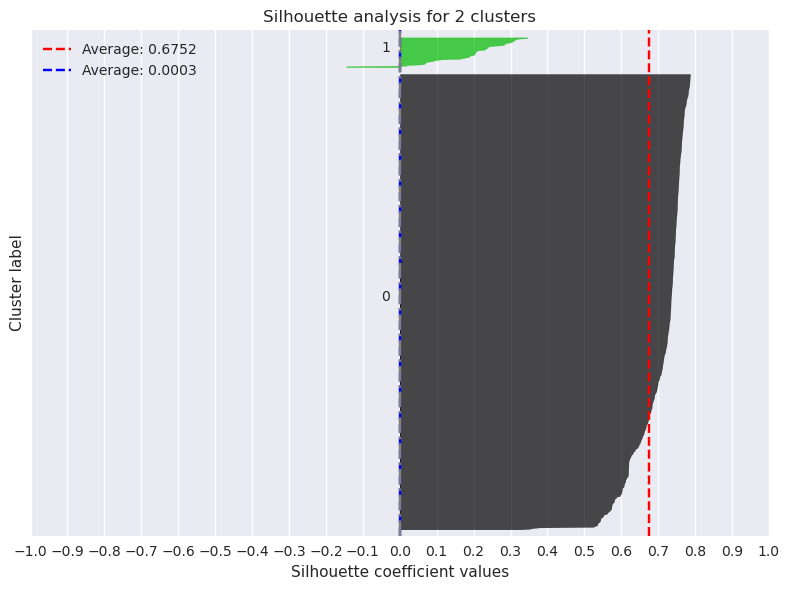

In [71]:

def plot_silhouette_analysis_from_embedding_df(df, n_clusters_range):
    """
    Performs silhouette analysis for a range of cluster numbers on a DataFrame
    where each column represents a dimension of the embedding vector.

    Args:
        df (pd.DataFrame): DataFrame where each column is an embedding dimension.
        n_clusters_range (list or range): List or range of the number of clusters to try.
    """

    embeddings = df.values
    random_embeddings = np.random.rand(*embeddings.shape)
    random_embeddings = 2 * np.random.rand(*embeddings.shape) - 1


    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(embeddings)

    for n_clusters in n_clusters_range:
        fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
        fig.set_size_inches(8, 6)

        # The 1st subplot is the silhouette plot
        ax1.set_xlim([-1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(scaled_embeddings) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters and a random generator
        # to get reproducible results on each run.
        clusterer = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
        cluster_labels = clusterer.fit_predict(scaled_embeddings)
        cluster_random_labels = clusterer.fit_predict(random_embeddings)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(scaled_embeddings, cluster_labels)
        random_silhouette_avg = silhouette_score(random_embeddings, cluster_random_labels)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(scaled_embeddings, cluster_labels)
        random_silhouette_values = silhouette_samples(random_embeddings, cluster_random_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            random_ith_cluster_silhouette_values = random_silhouette_values[cluster_random_labels == i]
            random_ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            size_cluster_i_random = random_ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            y_upper_random = y_lower + size_cluster_i_random

            color = plt.cm.nipy_spectral(float(i) / n_clusters)
            color_random = plt.cm.magma(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)
            
            ax1.fill_betweenx(np.arange(y_lower, y_upper_random),
                              0, random_ith_cluster_silhouette_values,
                              facecolor=color_random, edgecolor=color_random, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the gap

        ax1.set_title(f"Silhouette analysis for {n_clusters} clusters")
        ax1.set_xlabel("Silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for the average silhouette score of all the samples
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--", label=f"Average: {silhouette_avg:.4f}")
        ax1.axvline(x=random_silhouette_avg, color="blue", linestyle="--", label=f"Average: {random_silhouette_avg:.4f}")

        ax1.axvline(x=0, color="gray", linestyle="-.") # Indicate the 0 line
        ax1.legend()

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks(np.arange(-1, 1.1, 0.1))

        plt.tight_layout()
        plt.show()

    # Calculate the mean silhouette score across all samples for a chosen number of clusters
    # You might want to choose the 'best' number of clusters based on the plots
    best_n_clusters = n_clusters_range[0] # Or choose based on your analysis
    clusterer = KMeans(n_clusters=best_n_clusters, n_init=10, random_state=42)
    cluster_labels = clusterer.fit_predict(scaled_embeddings)
    mean_silhouette = silhouette_score(scaled_embeddings, cluster_labels)
    # print(f"\nMean silhouette score for {best_n_clusters} clusters: {mean_silhouette:.2f}")

    # You can also get the silhouette scores for each sample if needed
    sample_silhouette_values = silhouette_samples(scaled_embeddings, cluster_labels)
    return mean_silhouette, sample_silhouette_values

n_clusters_to_test = range(2, 3) # Try 2, 3, and 4 clusters

# --- Perform silhouette analysis and plot the results ---
mean_silhouette_score, sample_silhouette_values = plot_silhouette_analysis_from_embedding_df(
df_global_embeddings, n_clusters_to_test
)

## Split datasets

In [48]:
X = balanced_data.drop(columns = ['phage_id', 'bacteria_id', 'label', 'interaction'])
y = balanced_data['interaction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [49]:
print(f"X_train shape : {X_train.shape}, X_test shape : {X_test.shape}\n")

print(f"X_train shape : {y_train.shape}, X_test shape : {y_test.shape}\n")

X_train shape : (604, 8064), X_test shape : (152, 8064)

X_train shape : (604,), X_test shape : (152,)



# Random Forest

In [50]:
clf = make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=5, random_state=0))

clf.fit(X_train, y_train)

y_pred  = clf.predict(X_test)


## Get classification metrics

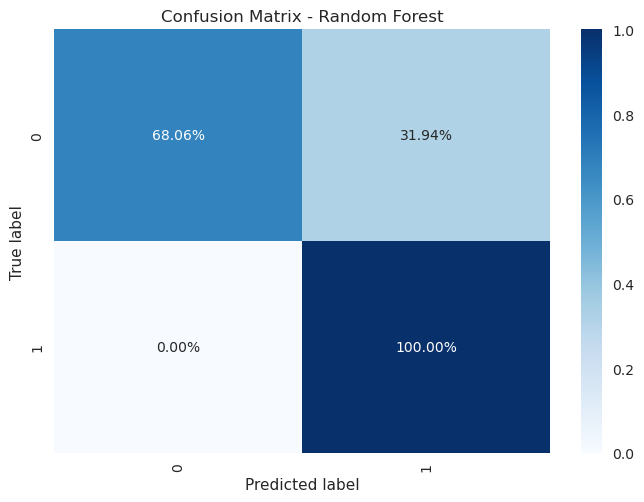

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2%', xticklabels=["0", "1"], yticklabels=["0", "1"], cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Random Forest')
plt.xticks(rotation=90)
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

In [52]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.68      0.81        72
           1       0.78      1.00      0.87        80

    accuracy                           0.85       152
   macro avg       0.89      0.84      0.84       152
weighted avg       0.88      0.85      0.84       152



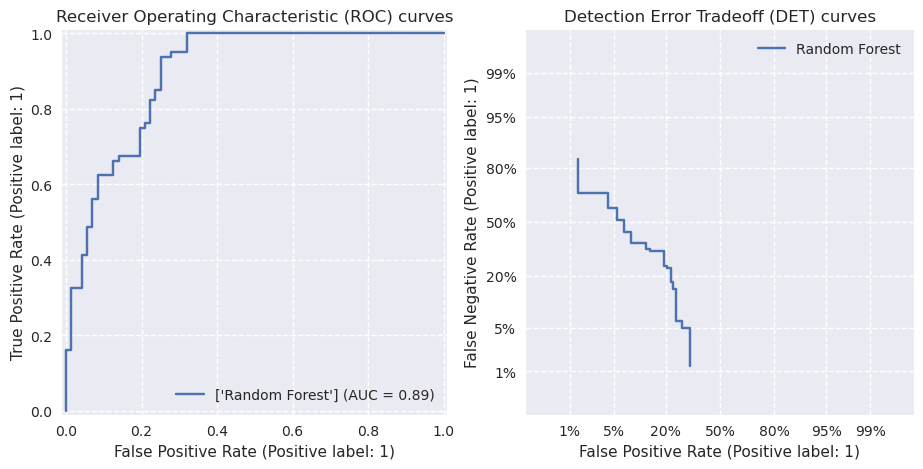

In [53]:
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

name = ['Random Forest']

RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name=name)
DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name=name)


ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()

## SVM

In [54]:
clf_svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))

clf_svm.fit(X_train, y_train)

y_pred = clf_svm.predict(X_test)

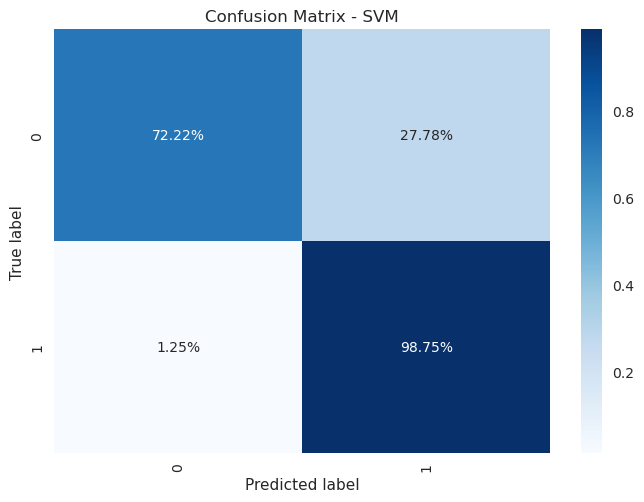

In [55]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2%', xticklabels=["0", "1"], yticklabels=["0", "1"], cmap=plt.cm.Blues)
plt.title('Confusion Matrix - SVM')
plt.xticks(rotation=90)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.72      0.83        72
           1       0.80      0.99      0.88        80

    accuracy                           0.86       152
   macro avg       0.89      0.85      0.86       152
weighted avg       0.88      0.86      0.86       152



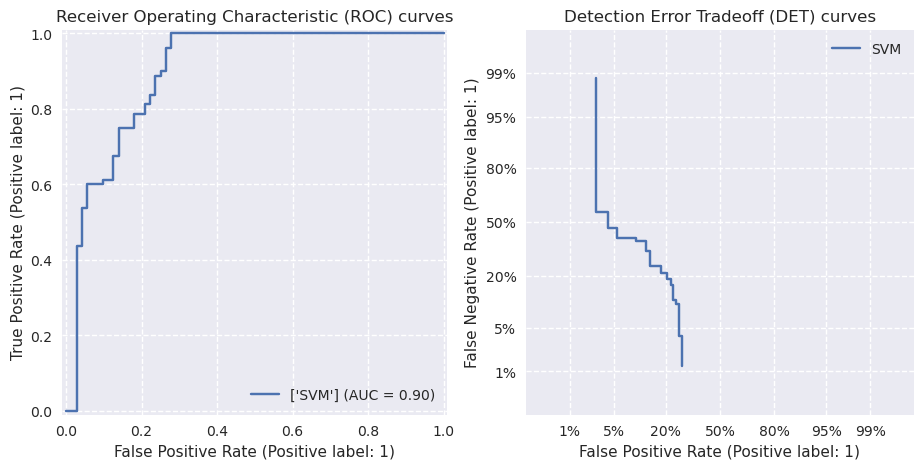

In [57]:
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

name = ['SVM']

RocCurveDisplay.from_estimator(clf_svm, X_test, y_test, ax=ax_roc, name=name)
DetCurveDisplay.from_estimator(clf_svm, X_test, y_test, ax=ax_det, name=name)


ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()

## XGBoost

In [58]:
clf_xgb = make_pipeline(StandardScaler(), XGBClassifier(max_depth = 15, random_state=42))
# Fit the model, test sets are used for early stopping.
clf_xgb.fit(X_train, y_train)

y_pred = clf_xgb.predict(X_test)

In [59]:
cm = confusion_matrix(y_test, y_pred)

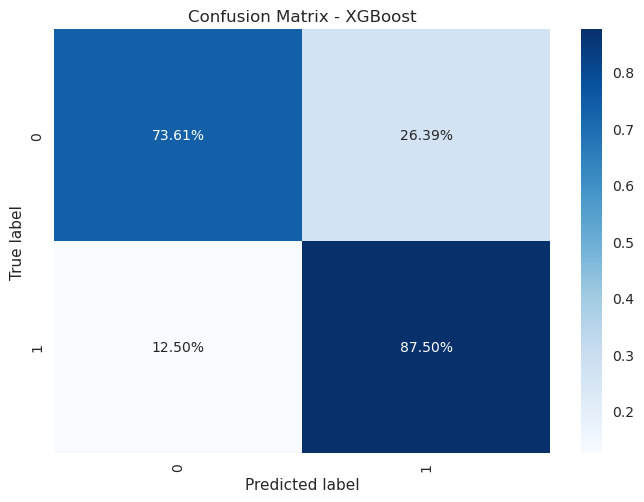

In [60]:
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2%', xticklabels=["0", "1"], yticklabels=["0", "1"], cmap=plt.cm.Blues)
plt.title('Confusion Matrix - XGBoost')
plt.xticks(rotation=90)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.74      0.79        72
           1       0.79      0.88      0.83        80

    accuracy                           0.81       152
   macro avg       0.81      0.81      0.81       152
weighted avg       0.81      0.81      0.81       152



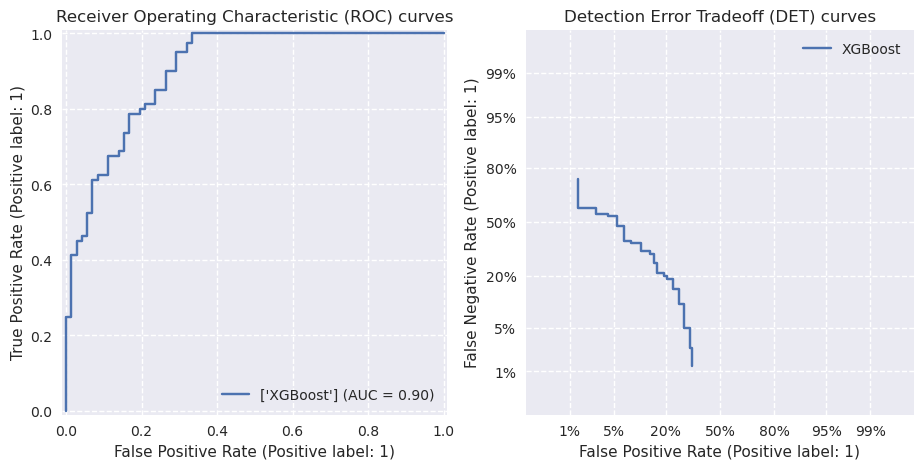

In [62]:
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

name = ['XGBoost']

RocCurveDisplay.from_estimator(clf_xgb, X_test, y_test, ax=ax_roc, name=name)
DetCurveDisplay.from_estimator(clf_xgb, X_test, y_test, ax=ax_det, name=name)


ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()

## AdaBoost

In [63]:
clf_adb = make_pipeline(StandardScaler(), AdaBoostClassifier(n_estimators=1000, random_state=42))

clf_adb.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('adaboostclassifier',
                 AdaBoostClassifier(n_estimators=1000, random_state=42))])

In [64]:
y_pred = clf_adb.predict(X_test)

In [65]:
cm = confusion_matrix(y_test, y_pred)

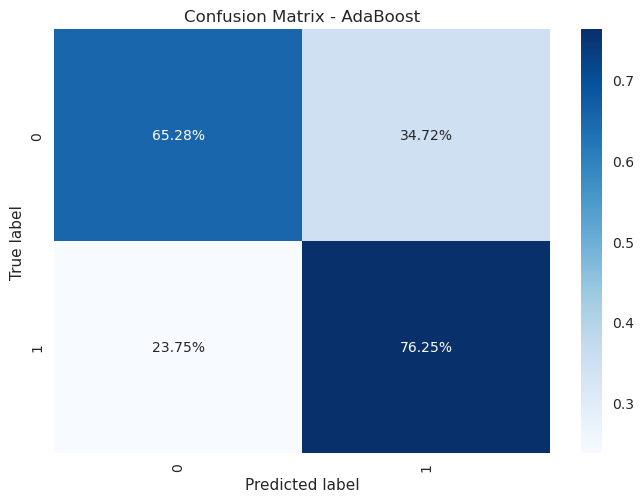

In [66]:
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2%', xticklabels=["0", "1"], yticklabels=["0", "1"], cmap=plt.cm.Blues)
plt.title('Confusion Matrix - AdaBoost')
plt.xticks(rotation=90)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [67]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.65      0.68        72
           1       0.71      0.76      0.73        80

    accuracy                           0.71       152
   macro avg       0.71      0.71      0.71       152
weighted avg       0.71      0.71      0.71       152



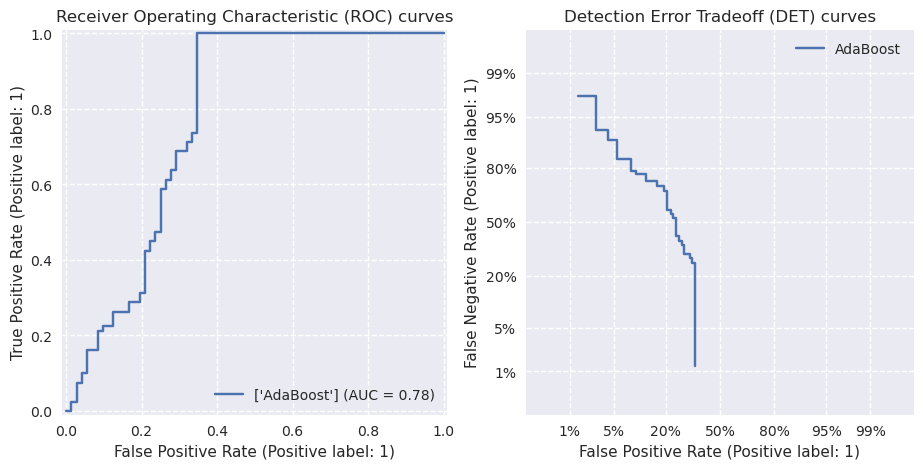

In [68]:
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

name = ['AdaBoost']

RocCurveDisplay.from_estimator(clf_adb, X_test, y_test, ax=ax_roc, name=name)
DetCurveDisplay.from_estimator(clf_adb, X_test, y_test, ax=ax_det, name=name)


ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()

## All classifiers

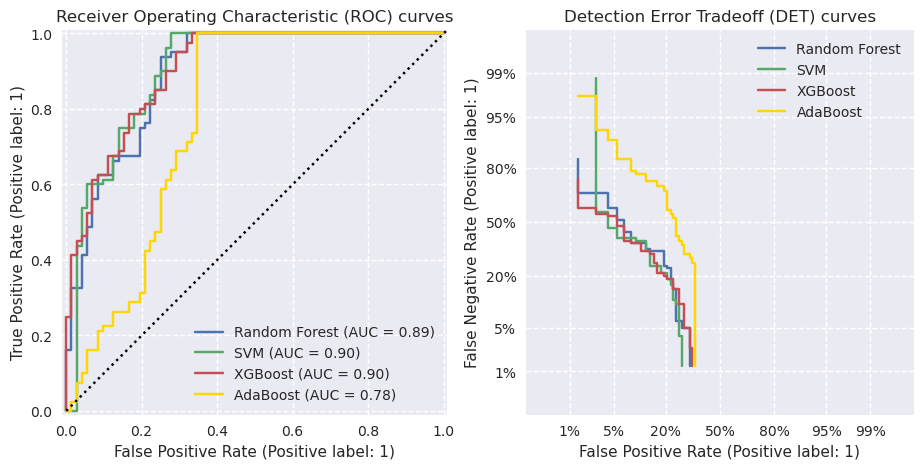

In [ ]:
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

plt

name = ['Random Forest']

RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name='Random Forest')
DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name='Random Forest')

RocCurveDisplay.from_estimator(clf_svm, X_test, y_test, ax=ax_roc, name="SVM")
DetCurveDisplay.from_estimator(clf_svm, X_test, y_test, ax=ax_det, name="SVM")

RocCurveDisplay.from_estimator(clf_xgb, X_test, y_test, ax=ax_roc, name= "XGBoost")
DetCurveDisplay.from_estimator(clf_xgb, X_test, y_test, ax=ax_det, name= "XGBoost")

RocCurveDisplay.from_estimator(clf_adb, X_test, y_test, ax=ax_roc, name="AdaBoost", color = "gold")
DetCurveDisplay.from_estimator(clf_adb, X_test, y_test, ax=ax_det, name="AdaBoost", color = "gold")

ax_roc.plot(np.arange(0, 1.5, 0.1), np.arange(0, 1.5, 0.1), linestyle= 'dotted', color = 'black')

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()